In [1]:
import geopandas as gpd
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from pyproj import CRS, Transformer
from shapely.geometry import Point

drive.mount('/content/drive') #if using google drive
user_path =  '/content/drive/MyDrive/' #Enter the path of the files

Mounted at /content/drive


In [2]:
# Conversion of Coordinates System
def convert_to_lat_lon(row):
    itm_crs = CRS.from_epsg(2039)
    wgs84_crs = CRS.from_epsg(4326)

# Create transformer object
    transformer = Transformer.from_crs(itm_crs, wgs84_crs, always_xy=True)
    longitude, latitude = transformer.transform(row['easting'], row['northing'])
    return pd.Series({'latitude': latitude, 'longitude': longitude})

In [3]:
#Change coordinate system
def lte_pre_proccessing(lte_stations_coordinates):
  lte_stations_coordinates.rename(columns={'X_ITM': 'easting', 'Y_ITM': 'northing'}, inplace=True)
  itm_crs = CRS.from_epsg(2039)
  wgs84_crs = CRS.from_epsg(4326)

# Create transformer object
  transformer = Transformer.from_crs(itm_crs, wgs84_crs, always_xy=True)
  lte_stations_coordinates[['latitude', 'longitude']] = lte_stations_coordinates.apply(convert_to_lat_lon, axis=1)

  lte_stations_coordinates.drop(columns=['easting', 'northing'], inplace=True)

In [4]:
# LTE data
# Assuming the original DataFrame is loaded as df
df_lte = pd.read_excel(user_path + 'lte_data.xlsx')

# Filter out inactive rows
df_active = df_lte[df_lte["טכנולוגיית שידור"] != "לא פעיל"]

# Create separate DataFrames for each company
df_phi = df_active[df_active["חברה"] == "PHI (משרת את הוט ופרטנר)"][["X_ITM", "Y_ITM"]]
df_cellcom = df_active[df_active["חברה"] == "סלקום"][["X_ITM", "Y_ITM"]]
df_pelephone = df_active[df_active["חברה"] == "פלאפון"][["X_ITM", "Y_ITM"]]

# Create a new DataFrame with only the X_ITM and Y_ITM columns
lte_stations_coordinates1 = df_lte[['X_ITM', 'Y_ITM']]

lte_pre_proccessing(lte_stations_coordinates1)
lte_pre_proccessing(df_phi)
lte_pre_proccessing(df_cellcom)
lte_pre_proccessing(df_pelephone)


# Display the new DataFrame
lte_stations_coordinates1.head()

<ipython-input-3-7eda3a1c40b7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lte_stations_coordinates.rename(columns={'X_ITM': 'easting', 'Y_ITM': 'northing'}, inplace=True)


KeyboardInterrupt: 

In [5]:
def convert_lte_to_geo_file(lte_stations_coordinates, file_name):
  geometry = [Point(xy) for xy in zip(lte_stations_coordinates.longitude, lte_stations_coordinates.latitude)]
  lte_gdf = gpd.GeoDataFrame(lte_stations_coordinates, geometry=geometry)
  print(lte_gdf.head())
  file_path = user_path + file_name + '.geojson'
  lte_gdf.to_file(file_path, driver='GeoJSON')

In [6]:

convert_lte_to_geo_file(df_phi, "phi_lte")
convert_lte_to_geo_file(df_cellcom, "cellcom_lte")
convert_lte_to_geo_file(df_pelephone, "pelephone_lte")



AttributeError: 'DataFrame' object has no attribute 'longitude'

In [7]:
def calculate_new_column(row):
    if pd.notna(row['אזור סטטיסטי']) and pd.notna(row['סמל יישוב']):
        if row['אזור סטטיסטי'] == 'סה"כ':
            return 1 + 10000 * row['סמל יישוב']
        else:
            return 10000 * row['סמל יישוב'] + int(row['אזור סטטיסטי'])
    return None



In [8]:
# poulation data merge
file_path = '/content/drive/MyDrive/population_statistical_area.xlsx'

# Load the data from the first sheet
df = pd.read_excel(file_path, sheet_name='גיליון1')

# Implement the algorithm to delete rows as specified by the user

# Identify the rows to be deleted
rows_to_delete = df[(df['אזור סטטיסטי'] == 'סה"כ') &
                    (df['סמל יישוב'] == df['סמל יישוב'].shift(-1))].index

# Delete the identified rows
df_cleaned = df.drop(rows_to_delete)
df_cleaned['area_number'] = df_cleaned.apply(calculate_new_column, axis=1)

df_final_population_area = df_cleaned[['area_number', 'אוכלוסייה בסוף 2022']]
df_final_population_area = df_final_population_area.dropna()



# Display the cleaned dataframe (optional)
df_final_population_area.head(1973)

area_number אוכלוסייה בסוף 2022
2      30000111.0                1460
3      30000112.0                1339
4      30000113.0                1971
5      30000114.0                2134
6      30000115.0                2630
...           ...                 ...
2050    7000001.0                 769
2051     130001.0                 368
2052    4220001.0                 585
2053    6630001.0                 602
2054    4620001.0                 683

[1973 rows x 2 columns]

CRS of Cellcom LTE: EPSG:4326
CRS of PHI LTE: EPSG:4326
CRS of Pelephone LTE: EPSG:4326
CRS of Statistical Areas: EPSG:3857
Cellcom Coverage Area: 21910.49 square kilometers
PHI Coverage Area: 20827.00 square kilometers
Pelephone Coverage Area: 21410.85 square kilometers


<ipython-input-11-cf3d5e9b7376>:56: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


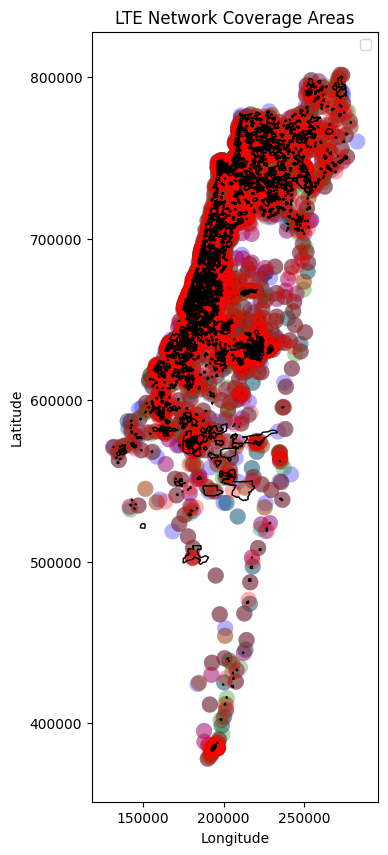

In [11]:

# All companies together
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the GeoJSON files
cellcom_lte = gpd.read_file(user_path + 'cellcom_lte.geojson')
phi_lte = gpd.read_file(user_path + 'phi_lte.geojson')
pelephone_lte = gpd.read_file(user_path + 'pelephone_lte.geojson')
statistical_areas = gpd.read_file(user_path + 'statistical_areas.geojson')

# Check CRS of the datasets
print("CRS of Cellcom LTE:", cellcom_lte.crs)
print("CRS of PHI LTE:", phi_lte.crs)
print("CRS of Pelephone LTE:", pelephone_lte.crs)
print("CRS of Statistical Areas:", statistical_areas.crs)

# Convert to a projected CRS (EPSG:2039 - Israel Transverse Mercator)
projected_crs = 'EPSG:2039'

cellcom_lte = cellcom_lte.to_crs(projected_crs)
phi_lte = phi_lte.to_crs(projected_crs)
pelephone_lte = pelephone_lte.to_crs(projected_crs)
statistical_areas = statistical_areas.to_crs(projected_crs)

# Buffer distance in meters (assumed average range of LTE base station)
buffer_distance = 5000  # in meters

# Create buffer zones around base stations
cellcom_lte['buffer'] = cellcom_lte.geometry.buffer(buffer_distance)
phi_lte['buffer'] = phi_lte.geometry.buffer(buffer_distance)
pelephone_lte['buffer'] = pelephone_lte.geometry.buffer(buffer_distance)

# Function to calculate total coverage area
def calculate_coverage_area(base_stations):
    coverage_area = base_stations['buffer'].unary_union.area
    return coverage_area

# Calculate coverage areas for each company
cellcom_coverage_area = calculate_coverage_area(cellcom_lte)
phi_coverage_area = calculate_coverage_area(phi_lte)
pelephone_coverage_area = calculate_coverage_area(pelephone_lte)

# Display coverage areas
print(f"Cellcom Coverage Area: {cellcom_coverage_area / 1e6:.2f} square kilometers")
print(f"PHI Coverage Area: {phi_coverage_area / 1e6:.2f} square kilometers")
print(f"Pelephone Coverage Area: {pelephone_coverage_area / 1e6:.2f} square kilometers")

# Plot the coverage areas
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
statistical_areas.boundary.plot(ax=ax, linewidth=1, edgecolor='black')

cellcom_lte['buffer'].plot(ax=ax, color='blue', alpha=0.3, label='Cellcom')
phi_lte['buffer'].plot(ax=ax, color='green', alpha=0.3, label='PHI')
pelephone_lte['buffer'].plot(ax=ax, color='red', alpha=0.3, label='Pelephone')

plt.legend()
plt.title("LTE Network Coverage Areas")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


<ipython-input-13-62ef7b067db3>:32: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


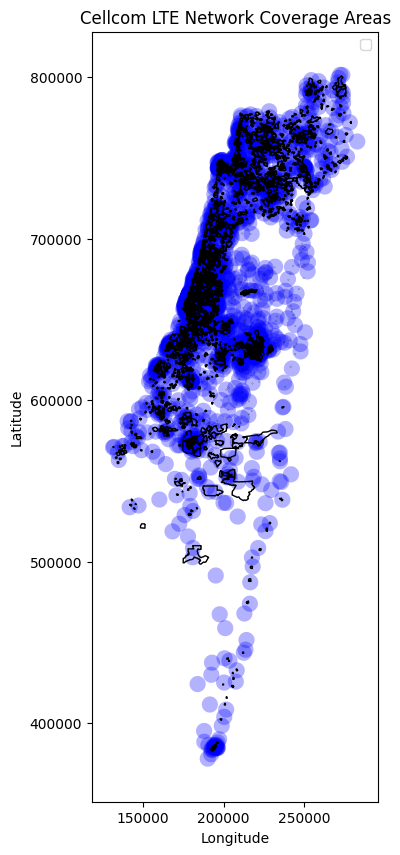

<ipython-input-13-62ef7b067db3>:32: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


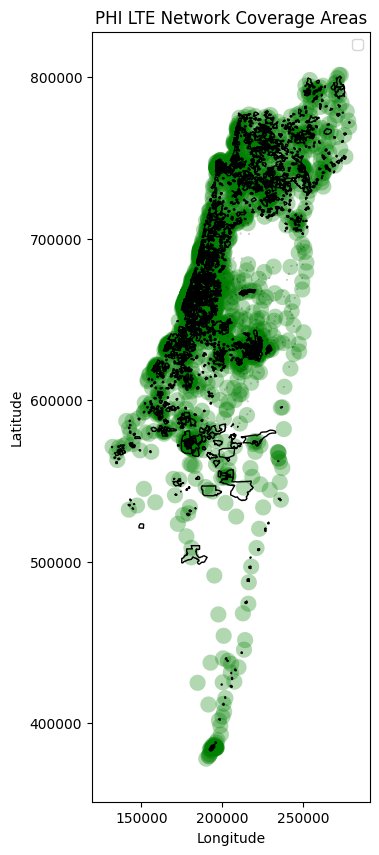

<ipython-input-13-62ef7b067db3>:32: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


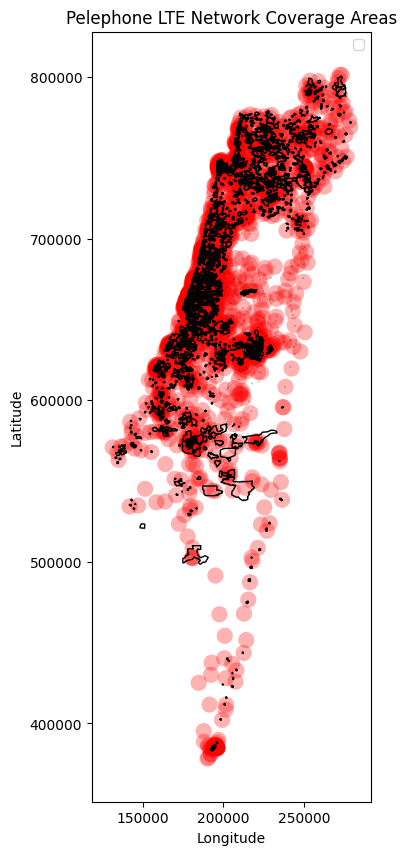

In [13]:
#All the companies seperatley
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the GeoJSON files
cellcom_lte = gpd.read_file(user_path + 'cellcom_lte.geojson')
phi_lte = gpd.read_file(user_path + 'phi_lte.geojson')
pelephone_lte = gpd.read_file(user_path + 'pelephone_lte.geojson')
statistical_areas = gpd.read_file(user_path + 'statistical_areas.geojson')

# Convert to a projected CRS (EPSG:2039 - Israel Transverse Mercator)
projected_crs = 'EPSG:2039'

cellcom_lte = cellcom_lte.to_crs(projected_crs)
phi_lte = phi_lte.to_crs(projected_crs)
pelephone_lte = pelephone_lte.to_crs(projected_crs)
statistical_areas = statistical_areas.to_crs(projected_crs)

# Buffer distance in meters (assumed average range of LTE base station)
buffer_distance = 5000  # in meters

# Create buffer zones around base stations
cellcom_lte['buffer'] = cellcom_lte.geometry.buffer(buffer_distance)
phi_lte['buffer'] = phi_lte.geometry.buffer(buffer_distance)
pelephone_lte['buffer'] = pelephone_lte.geometry.buffer(buffer_distance)

# Function to plot coverage area for a company
def plot_coverage_area(base_stations, company_name, color):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    statistical_areas.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
    base_stations['buffer'].plot(ax=ax, color=color, alpha=0.3, label=company_name)
    plt.legend()
    plt.title(f"{company_name} LTE Network Coverage Areas")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# Plot coverage areas for each company
plot_coverage_area(cellcom_lte, 'Cellcom', 'blue')
plot_coverage_area(phi_lte, 'PHI', 'green')
plot_coverage_area(pelephone_lte, 'Pelephone', 'red')

In [14]:
import geopandas as gpd
import pandas as pd

# Convert to a projected CRS (EPSG:2039 - Israel Transverse Mercator)
projected_crs = 'EPSG:2039'

cellcom_lte = cellcom_lte.to_crs(projected_crs)
phi_lte = phi_lte.to_crs(projected_crs)
pelephone_lte = pelephone_lte.to_crs(projected_crs)
statistical_areas = statistical_areas.to_crs(projected_crs)

# Ensure the population column is numeric
statistical_areas['Pop_Total'] = pd.to_numeric(statistical_areas['Pop_Total'], errors='coerce').fillna(0)

# Buffer distance in meters (assumed average range of LTE base station)
buffer_distance = 5000  # in meters

# Create buffer zones around base stations
cellcom_lte['buffer'] = cellcom_lte.geometry.buffer(buffer_distance)
phi_lte['buffer'] = phi_lte.geometry.buffer(buffer_distance)
pelephone_lte['buffer'] = pelephone_lte.geometry.buffer(buffer_distance)

# Combine all base stations
all_base_stations = gpd.GeoDataFrame(pd.concat([cellcom_lte, phi_lte, pelephone_lte], ignore_index=True))

# Function to calculate users per base station, dividing population equally in overlapping areas
def calculate_users_per_station(base_stations, areas):
    # Initialize users per station with zero
    base_stations['users'] = 0

    for idx, area in areas.iterrows():
        # Find base stations that cover this area
        covering_stations = base_stations[base_stations['buffer'].intersects(area.geometry)]
        num_stations = len(covering_stations)

        if num_stations > 0:
            # Divide the population equally among covering stations
            population_per_station = area['Pop_Total'] / num_stations

            for station_idx in covering_stations.index:
                base_stations.at[station_idx, 'users'] += population_per_station

    return base_stations

# Calculate users per station
base_stations_with_users = calculate_users_per_station(all_base_stations, statistical_areas)
average_users_per_station = base_stations_with_users['users'].mean()

print(f"Average number of users per base station: {average_users_per_station}")
print(base_stations_with_users[['users', 'geometry']])

<ipython-input-14-16e0f89efb80>:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '19.886363636363637' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  base_stations.at[station_idx, 'users'] += population_per_station


Average number of users per base station: 1098.5956054808048
            users                       geometry
0     1247.455476  POINT (178392.000 572490.000)
1      798.462977  POINT (186427.000 671098.000)
2      972.658178  POINT (194320.000 669652.000)
3      337.891453  POINT (144016.000 571592.000)
4     1155.317486  POINT (157629.000 615415.000)
...           ...                            ...
8096   831.420264  POINT (191667.000 655434.000)
8097   770.047511  POINT (196610.000 647481.000)
8098  1182.058996  POINT (190426.000 650658.000)
8099   741.405439  POINT (192044.000 655242.000)
8100   916.372469  POINT (191230.000 654156.000)

[8101 rows x 2 columns]


In [15]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load the bus stations locations file
bus_stations_df = pd.read_excel(user_path + 'bus_stations_location.xlsx')

# Create a GeoDataFrame from the bus stations DataFrame
geometry = [Point(xy) for xy in zip(bus_stations_df['Long'], bus_stations_df['Lat'])]
bus_stations_gdf = gpd.GeoDataFrame(bus_stations_df, geometry=geometry)

# Set the CRS (Coordinate Reference System) to WGS84 (latitude and longitude)
bus_stations_gdf.set_crs(epsg=4326, inplace=True)

# Save the bus stations GeoDataFrame to a GeoJSON file
bus_stations_gdf.to_file(user_path + 'bus_stations_location.geojson', driver='GeoJSON')

Total: 32078 bus stations under coverage, 170 bus stations not under coverage


<ipython-input-17-cb00056b0d77>:68: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  cellcom_lte_gdf.boundary.plot(ax=axs[0], color='red', linestyle='--', label='Cellcom LTE Coverage')
<ipython-input-17-cb00056b0d77>:77: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  phi_lte_gdf.boundary.plot(ax=axs[1], color='red', linestyle='--', label='PHI LTE Coverage')
<ipython-input-17-cb00056b0d77>:86: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  pelephone_lte_gdf.boundary.plot(ax=axs[2], color='red', linestyle='--', label='Pelephone LTE Coverage')


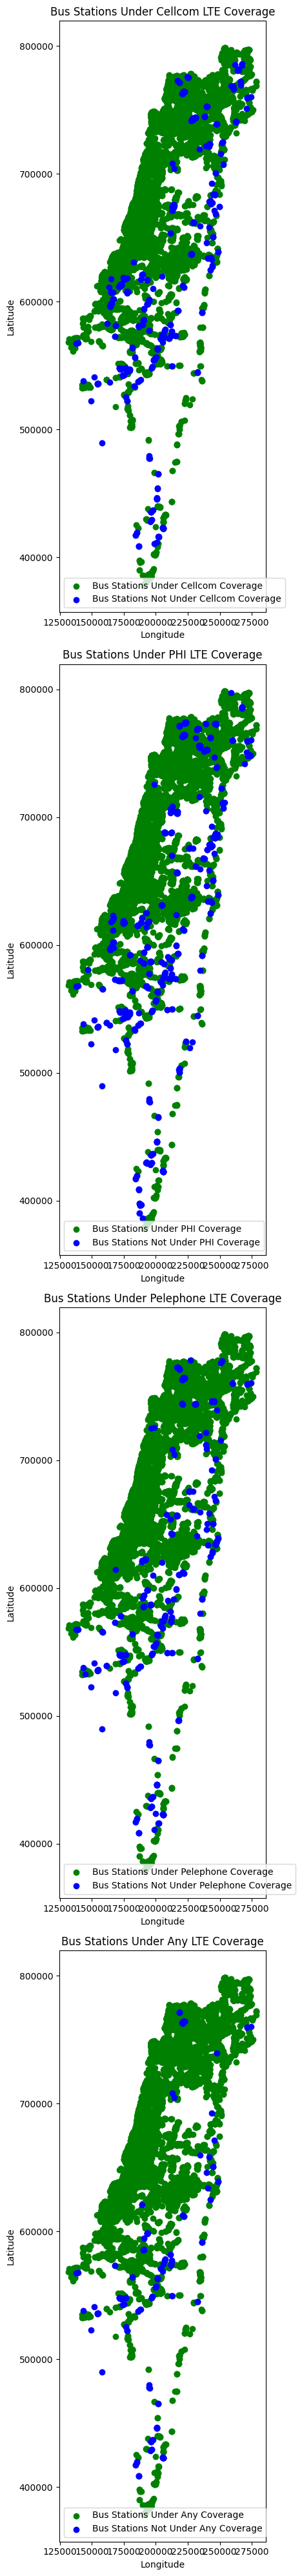

In [17]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Load bus stations locations file
bus_stations_df = pd.read_excel(user_path + 'bus_stations_location.xlsx')

# Convert bus stations to GeoDataFrame
bus_stations_gdf = gpd.GeoDataFrame(
    bus_stations_df,
    geometry=[Point(xy) for xy in zip(bus_stations_df['Long'], bus_stations_df['Lat'])],
    crs='EPSG:4326'  # Assuming the coordinates are in WGS84
)

# Load LTE base stations GeoJSON files for different companies
cellcom_lte_gdf = gpd.read_file(user_path + 'cellcom_lte.geojson')
phi_lte_gdf = gpd.read_file(user_path + 'phi_lte.geojson')
pelephone_lte_gdf = gpd.read_file(user_path + 'pelephone_lte.geojson')

# Convert all GeoDataFrames to a projected CRS (EPSG:2039 - Israel Transverse Mercator)
projected_crs = 'EPSG:2039'
bus_stations_gdf = bus_stations_gdf.to_crs(projected_crs)
cellcom_lte_gdf = cellcom_lte_gdf.to_crs(projected_crs)
phi_lte_gdf = phi_lte_gdf.to_crs(projected_crs)
pelephone_lte_gdf = pelephone_lte_gdf.to_crs(projected_crs)

# Buffer distance in meters (assumed average range of LTE base station)
buffer_distance = 3000  # in meters

# Create buffer zones around base stations for each company
cellcom_lte_gdf['buffer'] = cellcom_lte_gdf.geometry.buffer(buffer_distance)
phi_lte_gdf['buffer'] = phi_lte_gdf.geometry.buffer(buffer_distance)
pelephone_lte_gdf['buffer'] = pelephone_lte_gdf.geometry.buffer(buffer_distance)

# Function to check if bus stations are under coverage
def check_bus_stations_under_coverage(base_stations, bus_stations):
    # Check if each bus station is within any of the base station buffers
    bus_stations['under_coverage'] = bus_stations.apply(
        lambda row: base_stations['buffer'].intersects(row.geometry).any(), axis=1
    )
    return bus_stations

# Check bus stations under coverage for each company
bus_stations_with_coverage_cellcom = check_bus_stations_under_coverage(cellcom_lte_gdf, bus_stations_gdf.copy())
bus_stations_with_coverage_phi = check_bus_stations_under_coverage(phi_lte_gdf, bus_stations_gdf.copy())
bus_stations_with_coverage_pelephone = check_bus_stations_under_coverage(pelephone_lte_gdf, bus_stations_gdf.copy())

# Combine the coverage information
bus_stations_gdf['under_coverage_cellcom'] = bus_stations_with_coverage_cellcom['under_coverage']
bus_stations_gdf['under_coverage_phi'] = bus_stations_with_coverage_phi['under_coverage']
bus_stations_gdf['under_coverage_pelephone'] = bus_stations_with_coverage_pelephone['under_coverage']

# Determine if a bus station is under coverage by any company
bus_stations_gdf['under_coverage'] = bus_stations_gdf[['under_coverage_cellcom', 'under_coverage_phi', 'under_coverage_pelephone']].any(axis=1)

# Count the number of bus stations under coverage and not under coverage for all companies
total_under_coverage_count = bus_stations_gdf['under_coverage'].sum()
total_not_under_coverage_count = (~bus_stations_gdf['under_coverage']).sum()

# Print the results
print(f"Total: {total_under_coverage_count} bus stations under coverage, {total_not_under_coverage_count} bus stations not under coverage")

# Plotting the results
fig, axs = plt.subplots(4, 1, figsize=(10, 40))

# Plot Cellcom LTE base station coverage
cellcom_lte_gdf.boundary.plot(ax=axs[0], color='red', linestyle='--', label='Cellcom LTE Coverage')
bus_stations_with_coverage_cellcom[bus_stations_with_coverage_cellcom['under_coverage']].plot(ax=axs[0], color='green', label='Bus Stations Under Cellcom Coverage')
bus_stations_with_coverage_cellcom[~bus_stations_with_coverage_cellcom['under_coverage']].plot(ax=axs[0], color='blue', label='Bus Stations Not Under Cellcom Coverage')
axs[0].legend()
axs[0].set_title('Bus Stations Under Cellcom LTE Coverage')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')

# Plot PHI LTE base station coverage
phi_lte_gdf.boundary.plot(ax=axs[1], color='red', linestyle='--', label='PHI LTE Coverage')
bus_stations_with_coverage_phi[bus_stations_with_coverage_phi['under_coverage']].plot(ax=axs[1], color='green', label='Bus Stations Under PHI Coverage')
bus_stations_with_coverage_phi[~bus_stations_with_coverage_phi['under_coverage']].plot(ax=axs[1], color='blue', label='Bus Stations Not Under PHI Coverage')
axs[1].legend()
axs[1].set_title('Bus Stations Under PHI LTE Coverage')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')

# Plot Pelephone LTE base station coverage
pelephone_lte_gdf.boundary.plot(ax=axs[2], color='red', linestyle='--', label='Pelephone LTE Coverage')
bus_stations_with_coverage_pelephone[bus_stations_with_coverage_pelephone['under_coverage']].plot(ax=axs[2], color='green', label='Bus Stations Under Pelephone Coverage')
bus_stations_with_coverage_pelephone[~bus_stations_with_coverage_pelephone['under_coverage']].plot(ax=axs[2], color='blue', label='Bus Stations Not Under Pelephone Coverage')
axs[2].legend()
axs[2].set_title('Bus Stations Under Pelephone LTE Coverage')
axs[2].set_xlabel('Longitude')
axs[2].set_ylabel('Latitude')

# Plot total coverage
bus_stations_gdf[bus_stations_gdf['under_coverage']].plot(ax=axs[3], color='green', label='Bus Stations Under Any Coverage')
bus_stations_gdf[~bus_stations_gdf['under_coverage']].plot(ax=axs[3], color='blue', label='Bus Stations Not Under Any Coverage')
axs[3].legend()
axs[3].set_title('Bus Stations Under Any LTE Coverage')
axs[3].set_xlabel('Longitude')
axs[3].set_ylabel('Latitude')

plt.tight_layout()
plt.show()




In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load data
cellcom_lte = gpd.read_file('/content/drive/MyDrive/cellcom_lte.geojson')
phi_lte = gpd.read_file('/content/drive/MyDrive/phi_lte.geojson')
pelephone_lte = gpd.read_file('/content/drive/MyDrive/pelephone_lte.geojson')
statistical_areas = gpd.read_file('/content/drive/MyDrive/statistical_areas.geojson')

# Convert to a projected CRS (EPSG:2039 - Israel Transverse Mercator)
projected_crs = 'EPSG:2039'
cellcom_lte = cellcom_lte.to_crs(projected_crs)
phi_lte = phi_lte.to_crs(projected_crs)
pelephone_lte = pelephone_lte.to_crs(projected_crs)
statistical_areas = statistical_areas.to_crs(projected_crs)

# Ensure the population column is numeric
statistical_areas['Pop_Total'] = pd.to_numeric(statistical_areas['Pop_Total'], errors='coerce').fillna(0)

# Buffer distance in meters (assumed average range of LTE base station)
buffer_distance = 5000  # in meters

# Create buffer zones around base stations
cellcom_lte['buffer'] = cellcom_lte.geometry.buffer(buffer_distance)
phi_lte['buffer'] = phi_lte.geometry.buffer(buffer_distance)
pelephone_lte['buffer'] = pelephone_lte.geometry.buffer(buffer_distance)

# Combine all base stations
all_base_stations = gpd.GeoDataFrame(pd.concat([cellcom_lte, phi_lte, pelephone_lte], ignore_index=True))

# Function to calculate users per base station, dividing population equally in overlapping areas
def calculate_users_per_station(base_stations, areas):
    # Initialize users per station with zero
    base_stations['users'] = 0

    for idx, area in areas.iterrows():
        # Find base stations that cover this area
        covering_stations = base_stations[base_stations['buffer'].intersects(area.geometry)]
        num_stations = len(covering_stations)

        if num_stations > 0:
            # Divide the population equally among covering stations
            population_per_station = area['Pop_Total'] / num_stations

            for station_idx in covering_stations.index:
                base_stations.at[station_idx, 'users'] += population_per_station

    return base_stations

# Calculate users per station
base_stations_with_users = calculate_users_per_station(all_base_stations, statistical_areas)

# Initialize a dictionary to store the results
results = []

# Calculate the average number of users for base stations intersecting each statistical area
for idx, area in statistical_areas.iterrows():
    covering_stations = base_stations_with_users[base_stations_with_users['buffer'].intersects(area.geometry)]
    for station_idx, station in covering_stations.iterrows():
        result = {
            'statistical_area_id': idx,
            'statistical_area_name': area.get('SHEM_YISHUV_ENGLISH', 'N/A'),  # Assuming there's a 'name' column in statistical_areas
            'base_station_id': station_idx,
            'base_station_users': station['users']
        }
        results.append(result)

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df.head())

# Save the results to a CSV file
results_df.to_csv('/content/drive/MyDrive/buffer_regions_coverage2.csv', index=False)

   statistical_area_id statistical_area_name  base_station_id  \
0                    0                SHAHAR               49   
1                    0                SHAHAR              245   
2                    0                SHAHAR              718   
3                    0                SHAHAR              742   
4                    0                SHAHAR              915   

   base_station_users  
0         1001.144175  
1         1077.347053  
2         1173.875091  
3         1090.358074  
4         1000.317252  


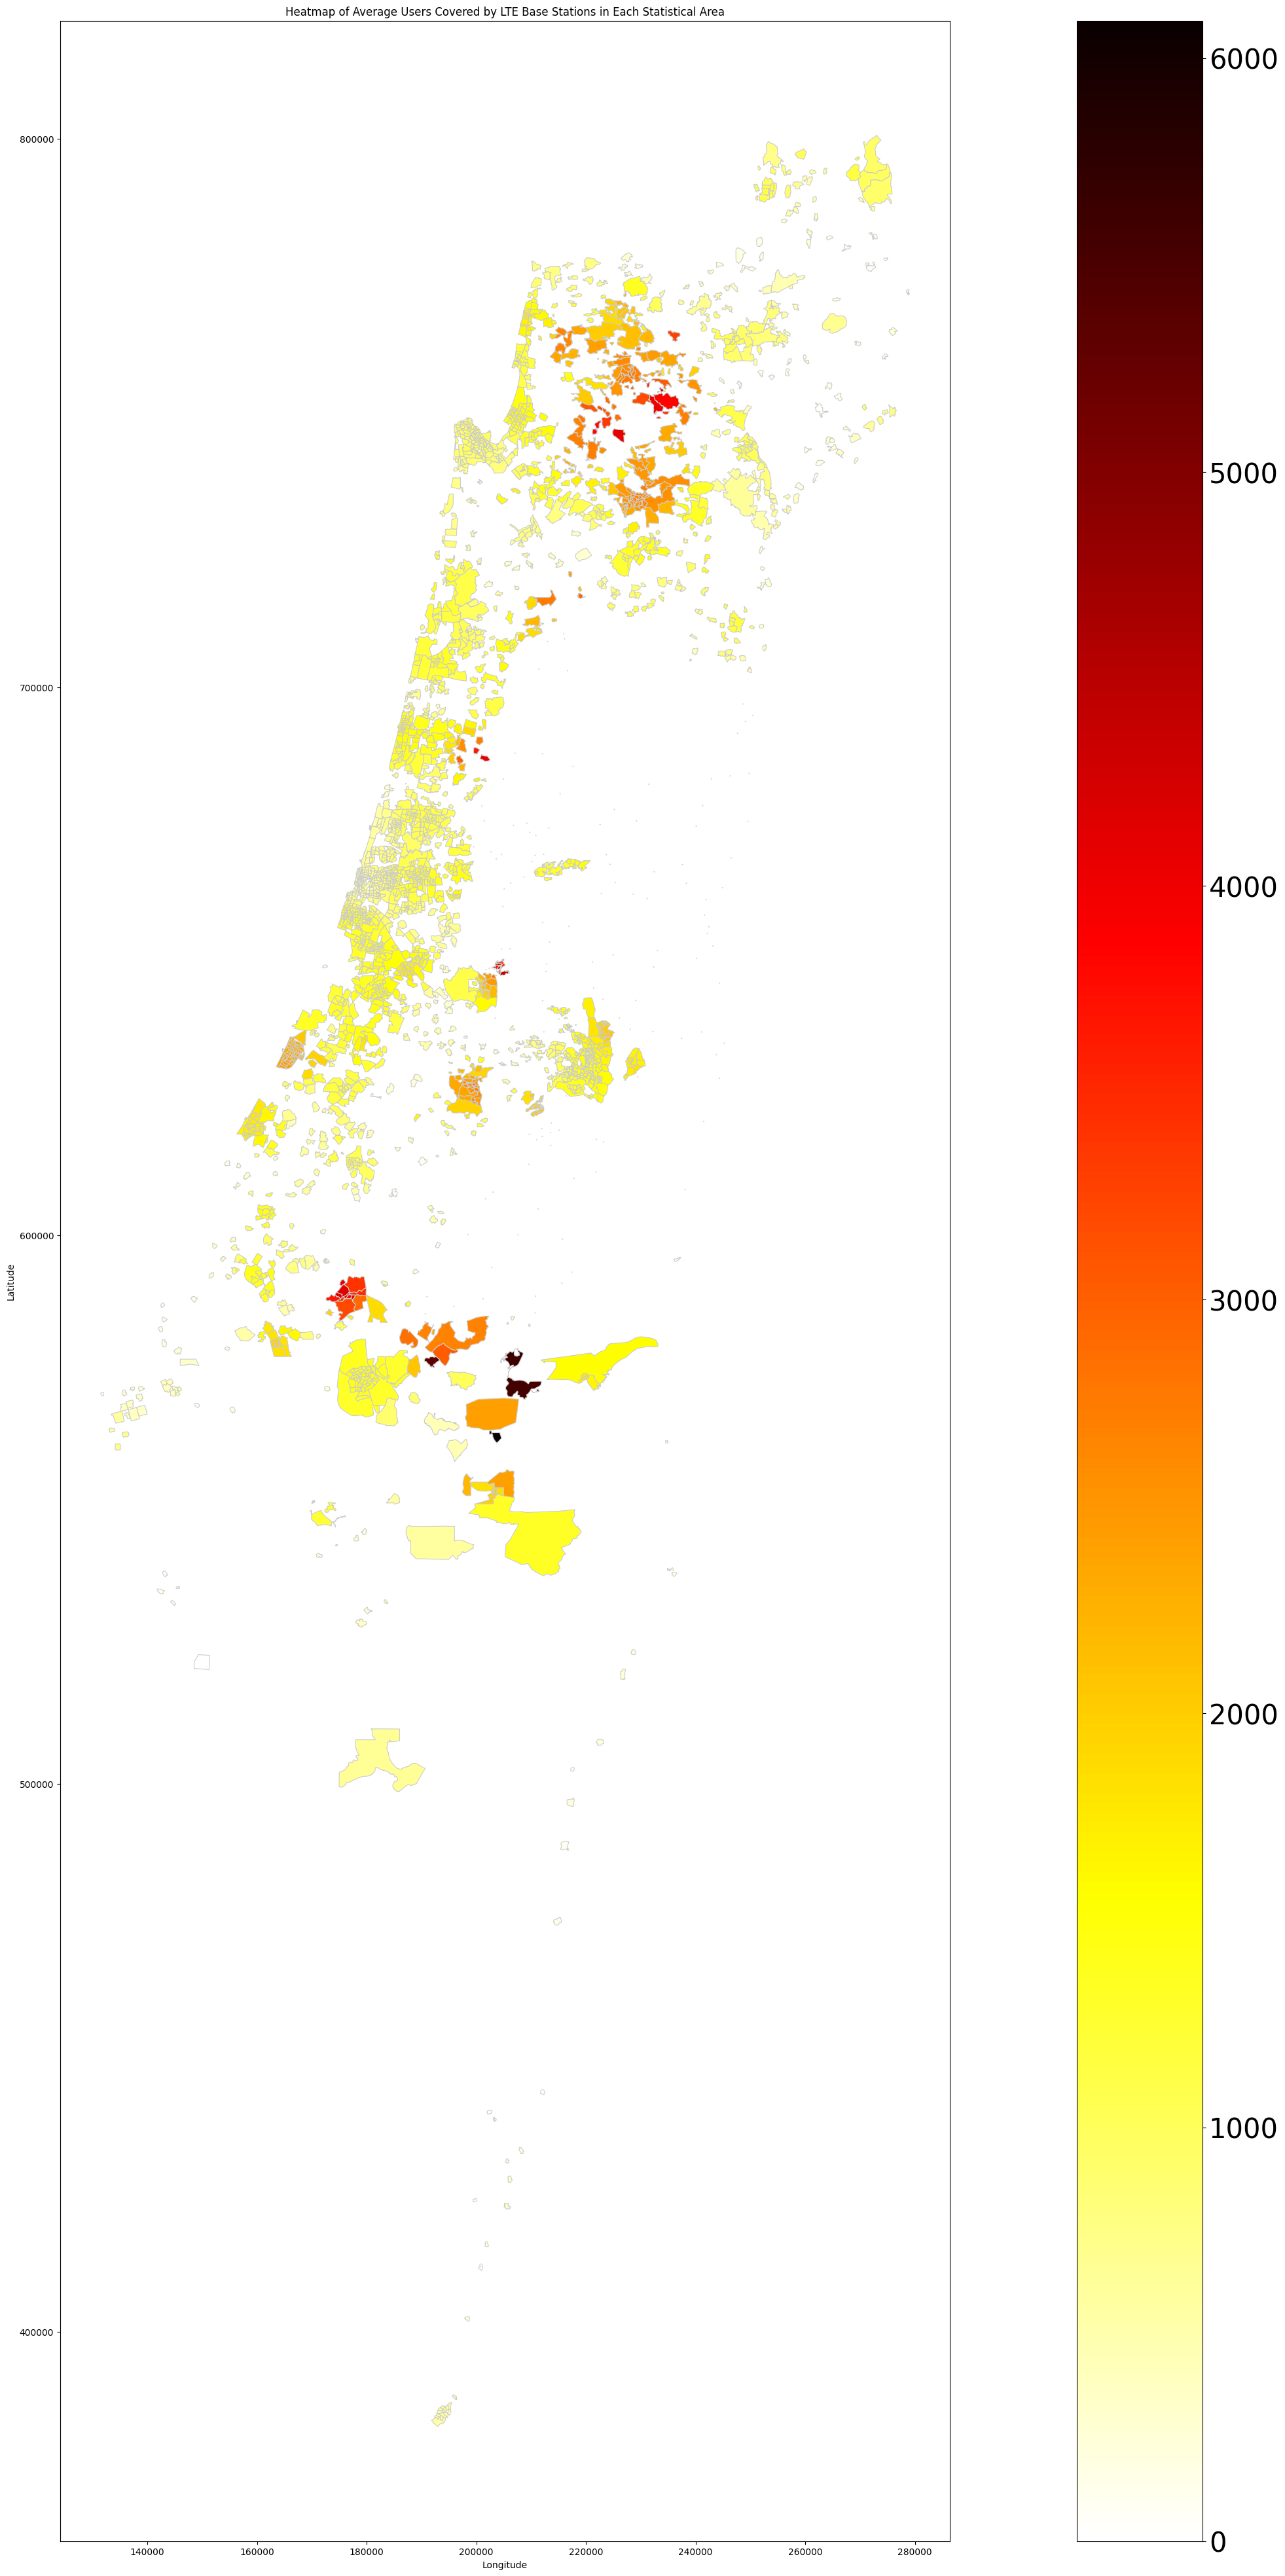

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load data
cellcom_lte = gpd.read_file('/content/drive/MyDrive/cellcom_lte.geojson')
phi_lte = gpd.read_file('/content/drive/MyDrive/phi_lte.geojson')
pelephone_lte = gpd.read_file('/content/drive/MyDrive/pelephone_lte.geojson')
statistical_areas = gpd.read_file('/content/drive/MyDrive/statistical_areas.geojson')

# Convert to a projected CRS (EPSG:2039 - Israel Transverse Mercator)
projected_crs = 'EPSG:2039'
cellcom_lte = cellcom_lte.to_crs(projected_crs)
phi_lte = phi_lte.to_crs(projected_crs)
pelephone_lte = pelephone_lte.to_crs(projected_crs)
statistical_areas = statistical_areas.to_crs(projected_crs)

# Ensure the population column is numeric
statistical_areas['Pop_Total'] = pd.to_numeric(statistical_areas['Pop_Total'], errors='coerce').fillna(0)

# Buffer distance in meters (assumed average range of LTE base station)
buffer_distance = 3000  # in meters

# Create buffer zones around base stations
cellcom_lte['buffer'] = cellcom_lte.geometry.buffer(buffer_distance)
phi_lte['buffer'] = phi_lte.geometry.buffer(buffer_distance)
pelephone_lte['buffer'] = pelephone_lte.geometry.buffer(buffer_distance)

# Combine all base stations
all_base_stations = gpd.GeoDataFrame(pd.concat([cellcom_lte, phi_lte, pelephone_lte], ignore_index=True))

# Function to calculate users per base station, dividing population equally in overlapping areas
def calculate_users_per_station(base_stations, areas):
    # Initialize users per station with zero
    base_stations['users'] = 0

    for idx, area in areas.iterrows():
        # Find base stations that cover this area
        covering_stations = base_stations[base_stations['buffer'].intersects(area.geometry)]
        num_stations = len(covering_stations)

        if num_stations > 0:
            # Divide the population equally among covering stations
            population_per_station = area['Pop_Total'] / num_stations

            for station_idx in covering_stations.index:
                base_stations.at[station_idx, 'users'] += population_per_station

    return base_stations

# Calculate users per station
base_stations_with_users = calculate_users_per_station(all_base_stations, statistical_areas)

# Initialize a dictionary to store the results
results = []

# Calculate the average number of users for base stations intersecting each statistical area
for idx, area in statistical_areas.iterrows():
    covering_stations = base_stations_with_users[base_stations_with_users['buffer'].intersects(area.geometry)]
    if len(covering_stations) > 0:
        average_users_in_area = covering_stations['users'].mean()
    else:
        average_users_in_area = 0
    result = {
        'statistical_area_id': idx,
        'statistical_area_name': area.get('name', 'N/A'),  # Assuming there's a 'name' column in statistical_areas
        'average_users': average_users_in_area
    }
    results.append(result)

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Merge the results back to the statistical_areas GeoDataFrame
statistical_areas = statistical_areas.merge(results_df, left_index=True, right_on='statistical_area_id')

# Generate heatmap with basemap
fig, ax = plt.subplots(figsize=(50, 50))
plt.title('Heatmap of Average Users Covered by LTE Base Stations in Each Statistical Area')

# Normalize population values for colormap with scale 0 to maximum average users
norm = plt.Normalize(vmin=0, vmax=results_df['average_users'].max())
cmap = plt.cm.hot_r

# Plot heatmap
plot = statistical_areas.plot(column='average_users', cmap=cmap, linewidth=0.8, edgecolor='0.8', norm=norm, ax=ax, legend=False)

# Add colorbar with increased font size
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.tick_params(labelsize=30)  # Increase colorbar font size

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


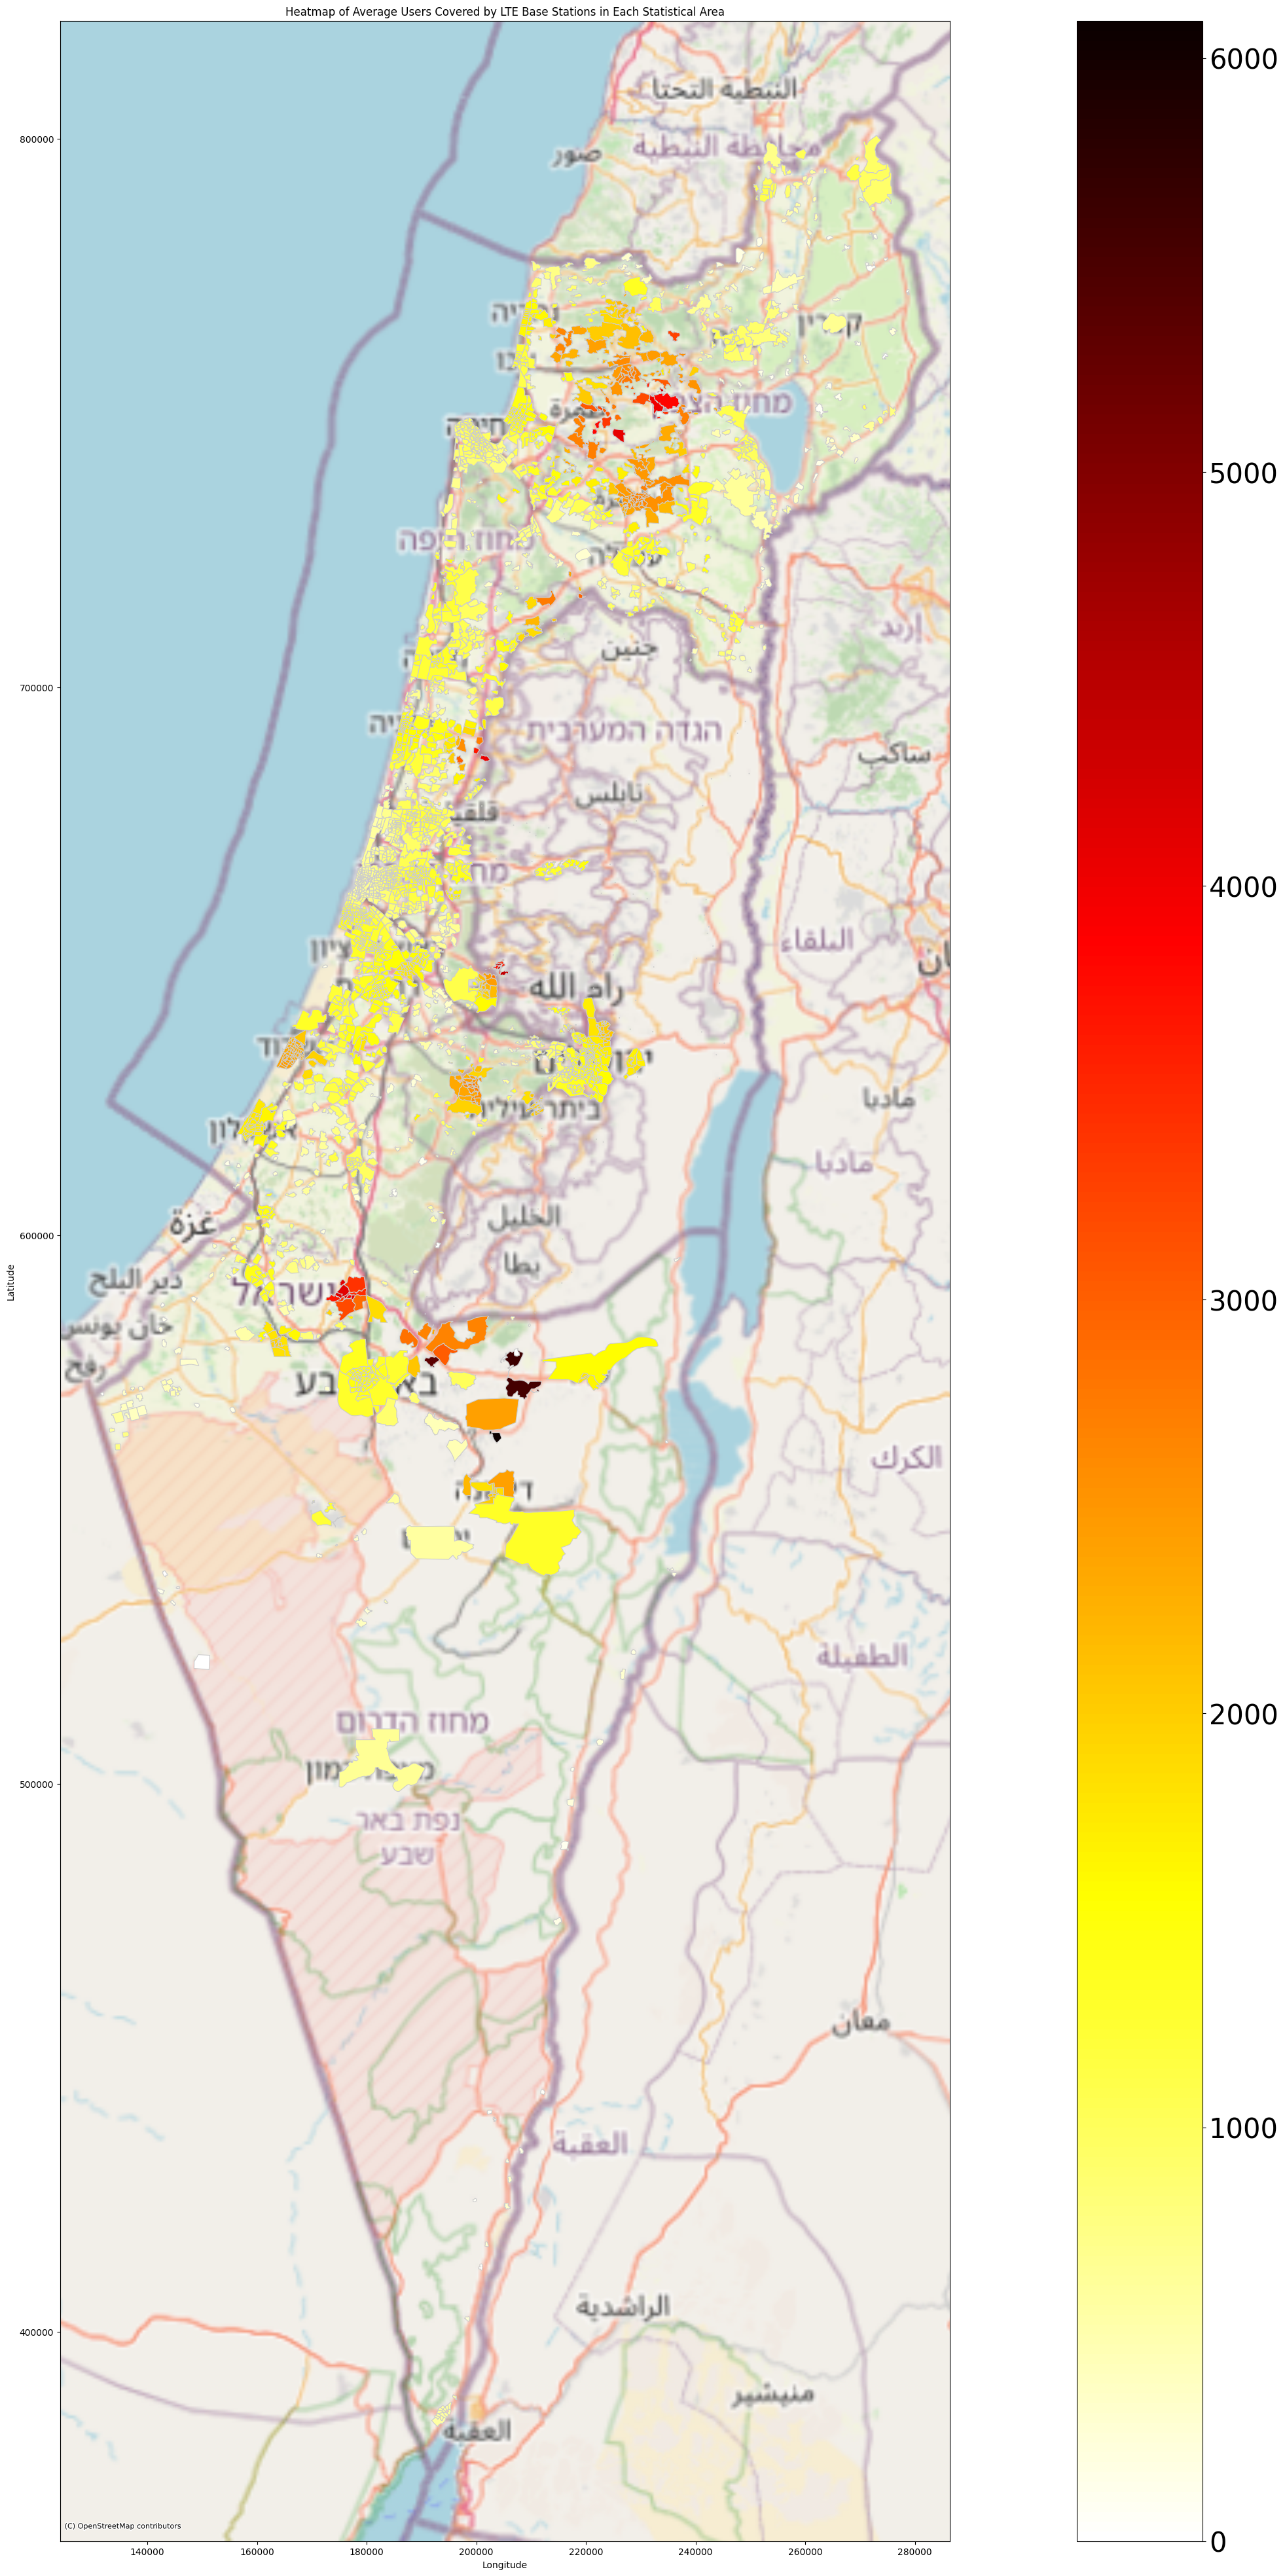

In [ ]:

import contextily as ctx

# Generate heatmap with basemap
fig, ax = plt.subplots(figsize=(50, 50))
plt.title('Heatmap of Average Users Covered by LTE Base Stations in Each Statistical Area')

# Normalize population values for colormap with scale 0 to maximum average users
norm = plt.Normalize(vmin=0, vmax=results_df['average_users'].max())
cmap = plt.cm.hot_r

# Plot heatmap
plot = statistical_areas.plot(column='average_users', cmap=cmap, linewidth=0.8, edgecolor='0.8', norm=norm, ax=ax, legend=False)

# Add colorbar with increased font size
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax)
cbar.ax.tick_params(labelsize=30)  # Increase colorbar font size

# Add basemap
ctx.add_basemap(ax, crs=statistical_areas.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:


def plot_average_users_per_city(statistical_areas, cities_list):
    """
    Plots the average number of users per city covered by LTE base stations for the given list of cities.


    """
    # Filter the dataframe to include only the cities in the input list
    filtered_statistical_areas = statistical_areas[statistical_areas['SHEM_YISHUV_ENGLISH'].isin(cities_list)]

    # Calculate the average number of users per city
    average_users_per_city = filtered_statistical_areas.groupby('SHEM_YISHUV_ENGLISH')['average_users'].mean().reset_index()

    # Sort the cities for better visualization
    average_users_per_city = average_users_per_city.sort_values(by='average_users', ascending=False)

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.bar(average_users_per_city['SHEM_YISHUV_ENGLISH'], average_users_per_city['average_users'], color='skyblue')
    plt.xlabel('City')
    plt.ylabel('Average Number of Users')
    plt.title('Average Number of Users per City Covered by LTE Base Stations')
    plt.ylim(0, 6000)  # Set the scale of the y-axis
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


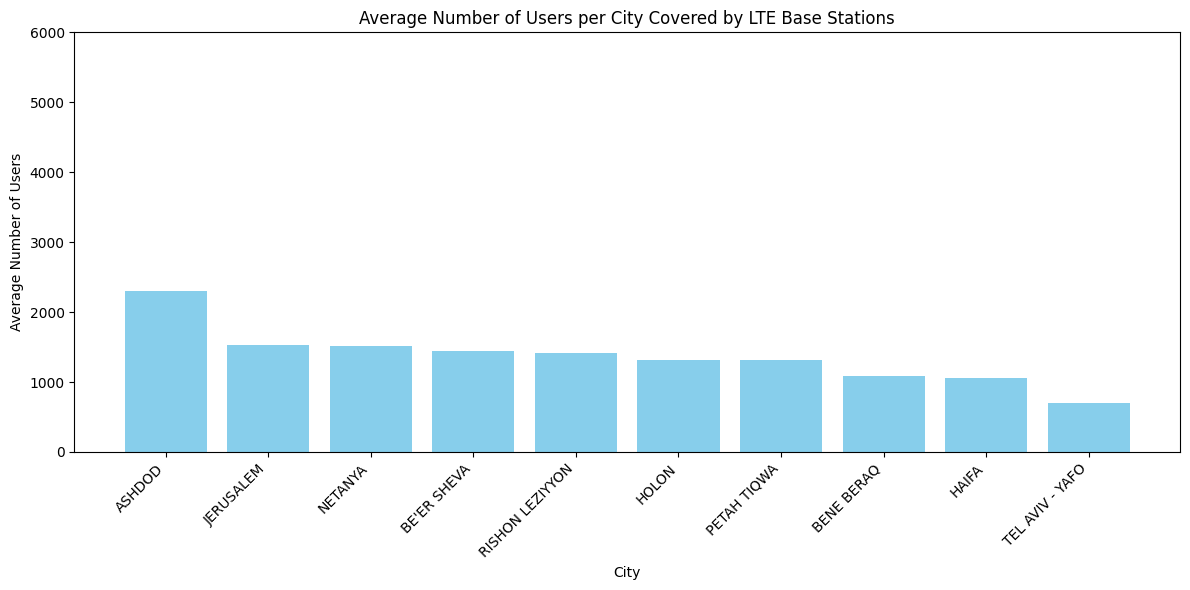

In [ ]:
cities_list_biggest = ['JERUSALEM', 'HAIFA', 'ASHDOD', 'TEL AVIV - YAFO', 'RISHON LEZIYYON', 'PETAH TIQWA', 'NETANYA', 'BENE BERAQ', "BE'ER SHEVA", 'HOLON']  # Replace with the actual list of cities you want to plot
plot_average_users_per_city(statistical_areas, cities_list_biggest)

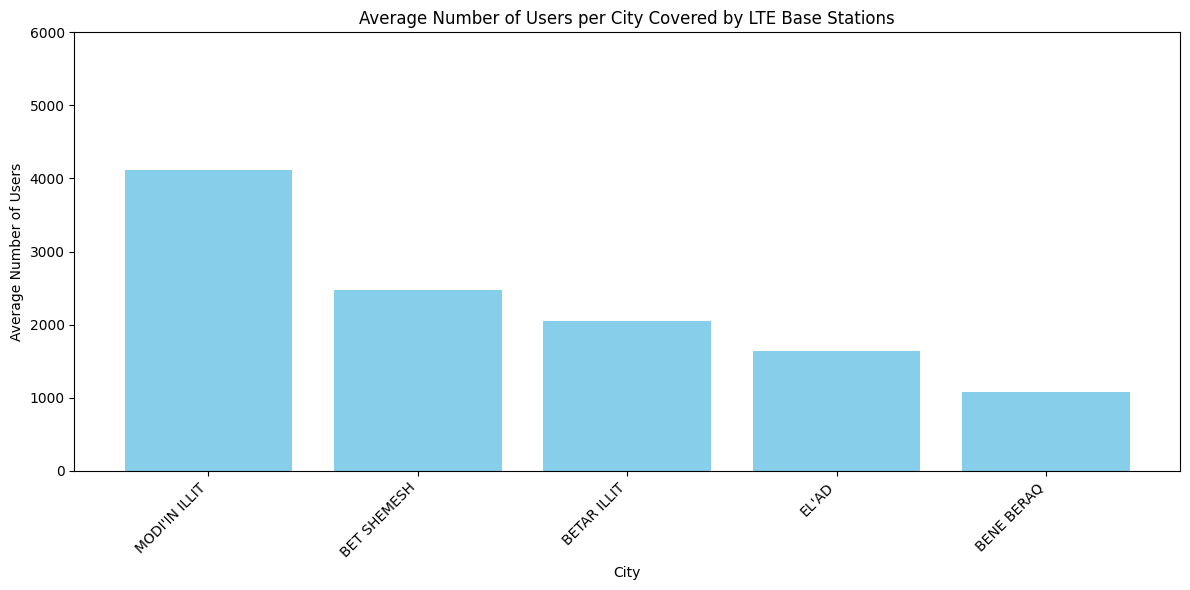

In [ ]:
haredi_cities = ['BENE BERAQ', "EL'AD", "MODI'IN ILLIT", "BETAR ILLIT", 'BET SHEMESH']
plot_average_users_per_city(statistical_areas, haredi_cities)

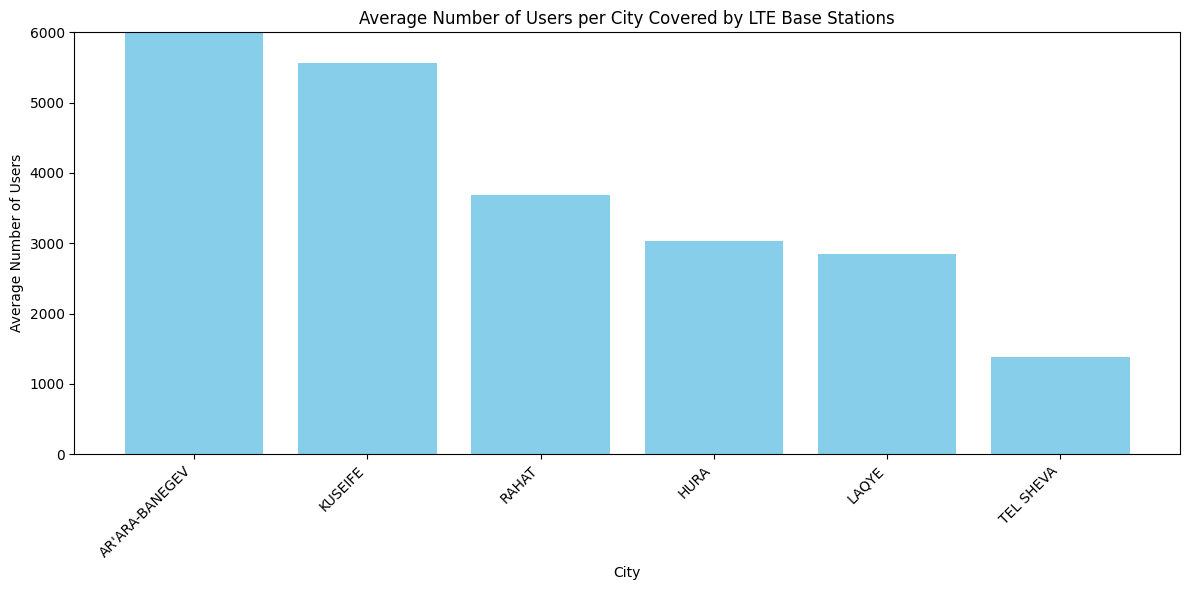

In [ ]:
bedwi_cities = ['KUSEIFE', "RAHAT", "LAQYE", "TEL SHEVA", 'HURA', "AR'ARA-BANEGEV"]
plot_average_users_per_city(statistical_areas, bedwi_cities)

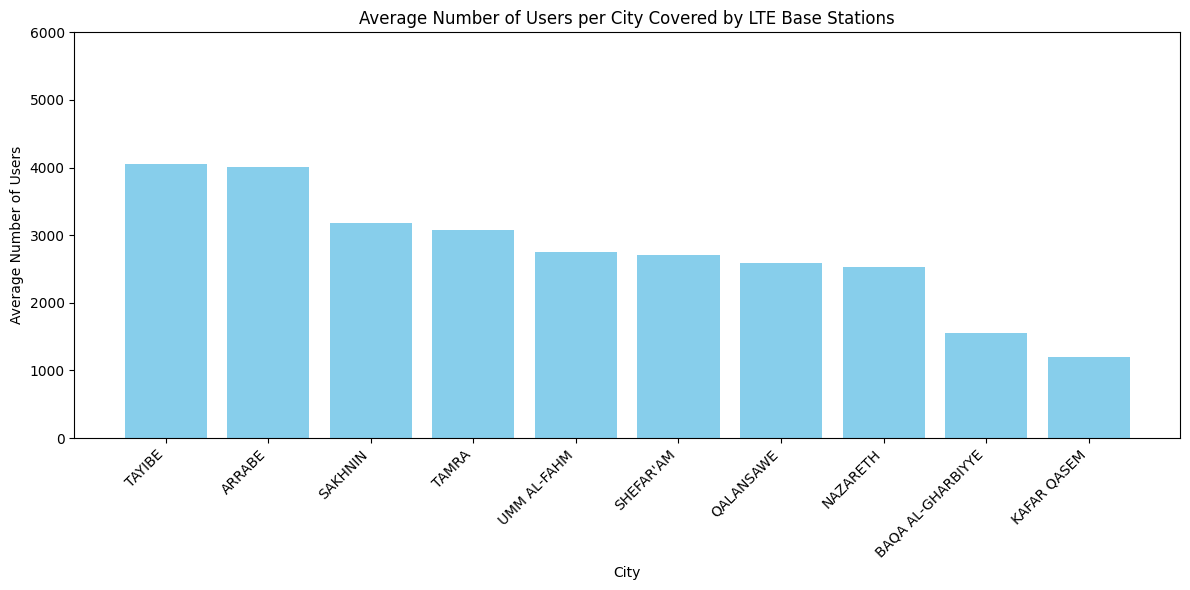

In [ ]:
arab_cities = ['UMM AL-FAHM', "TAYIBE", "QALANSAWE", "BAQA AL-GHARBIYYE", 'SAKHNIN', "NAZARETH", "SHEFAR'AM", "ARRABE", "TAMRA", "KAFAR QASEM"]
plot_average_users_per_city(statistical_areas, arab_cities)

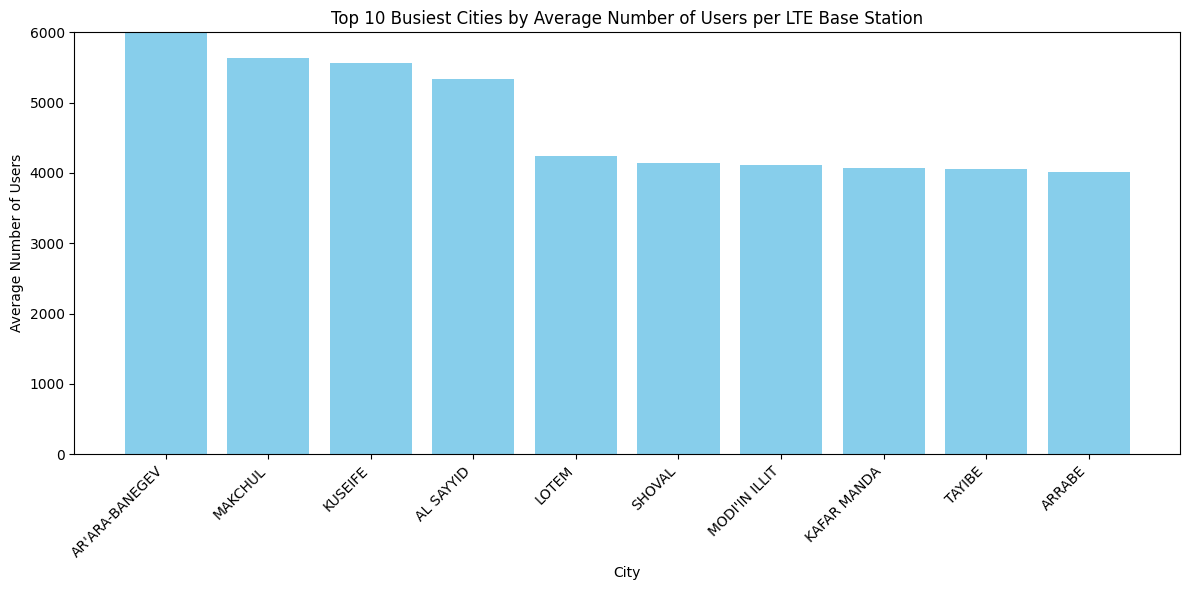

In [ ]:
def plot_top_10_busiest_cities(statistical_areas):
    """
    Plots the top 10 busiest cities based on the average number of users per LTE base station.

    Parameters:
    statistical_areas (GeoDataFrame): GeoDataFrame containing the statistical areas data with 'city' and 'average_users' columns.
    """
    # Calculate the average number of users per city
    average_users_per_city = statistical_areas.groupby('SHEM_YISHUV_ENGLISH')['average_users'].mean().reset_index()

    # Sort the cities to get the top 10 busiest
    top_10_busiest_cities = average_users_per_city.sort_values(by='average_users', ascending=False).head(10)

    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.bar(top_10_busiest_cities['SHEM_YISHUV_ENGLISH'], top_10_busiest_cities['average_users'], color='skyblue')
    plt.xlabel('City')
    plt.ylabel('Average Number of Users')
    plt.title('Top 10 Busiest Cities by Average Number of Users per LTE Base Station')
    plt.ylim(0, 6000)  # Set the scale of the y-axis
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'statistical_areas' is a GeoDataFrame with 'city' and 'average_users' columns
plot_top_10_busiest_cities(statistical_areas)